In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import binomtest
import seaborn as sns
%matplotlib inline

plt.style.use('ggplot')
plt.rc("figure", figsize=(16, 10))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [2]:
#Parametrit

years = 3
tickers = ['KCR.HE', 'TIETO.HE', 'TYRES.HE']
moving_avg = 21
test_frame = 251

In [3]:
#Ajan asettaminen ja datan lataaminen sekä logaritmisten tuottojen laskeminen

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days= 365 * years)

data = yf.download(tickers, start= start_date, end= end_date, interval= '1d')['Adj Close']
log_returns = np.log(data/data.shift(1)).dropna()

[*********************100%***********************]  3 of 3 completed


In [4]:
#Portfolion painojen asettaminen ja portfolion tuottojen liukuvien keskiarvojen laskeminen

weights = np.array([1/len(tickers)] * len(tickers))
historical_returns = (log_returns * weights).sum(axis= 1)
rolling_means = historical_returns.rolling(window= moving_avg).mean().dropna()

In [10]:
#VaR:n laskeminen ja taulukointi DataFrameksi

def rolling_percentile_VaR1(window):
    return -np.percentile(window, 100 * (1 - 0.99))

def rolling_percentile_VaR2(window):
    return -np.percentile(window, 100 * (1 - 0.95))

def rolling_percentile_VaR3(window):
    return -np.percentile(window, 100 * (1 - 0.90))

VaR1 = historical_returns.rolling(window=moving_avg).apply(rolling_percentile_VaR1, raw=False)
VaR2 = historical_returns.rolling(window=moving_avg).apply(rolling_percentile_VaR2, raw=False)
VaR3 = historical_returns.rolling(window=moving_avg).apply(rolling_percentile_VaR3, raw=False)

VaR1 = VaR1.rename("99 % VaR")
VaR2 = VaR2.rename("95 % VaR")
VaR3 = VaR3.rename("90 % VaR")

VaRs = pd.concat([VaR1, VaR2, VaR3], axis= 1).tail(test_frame)

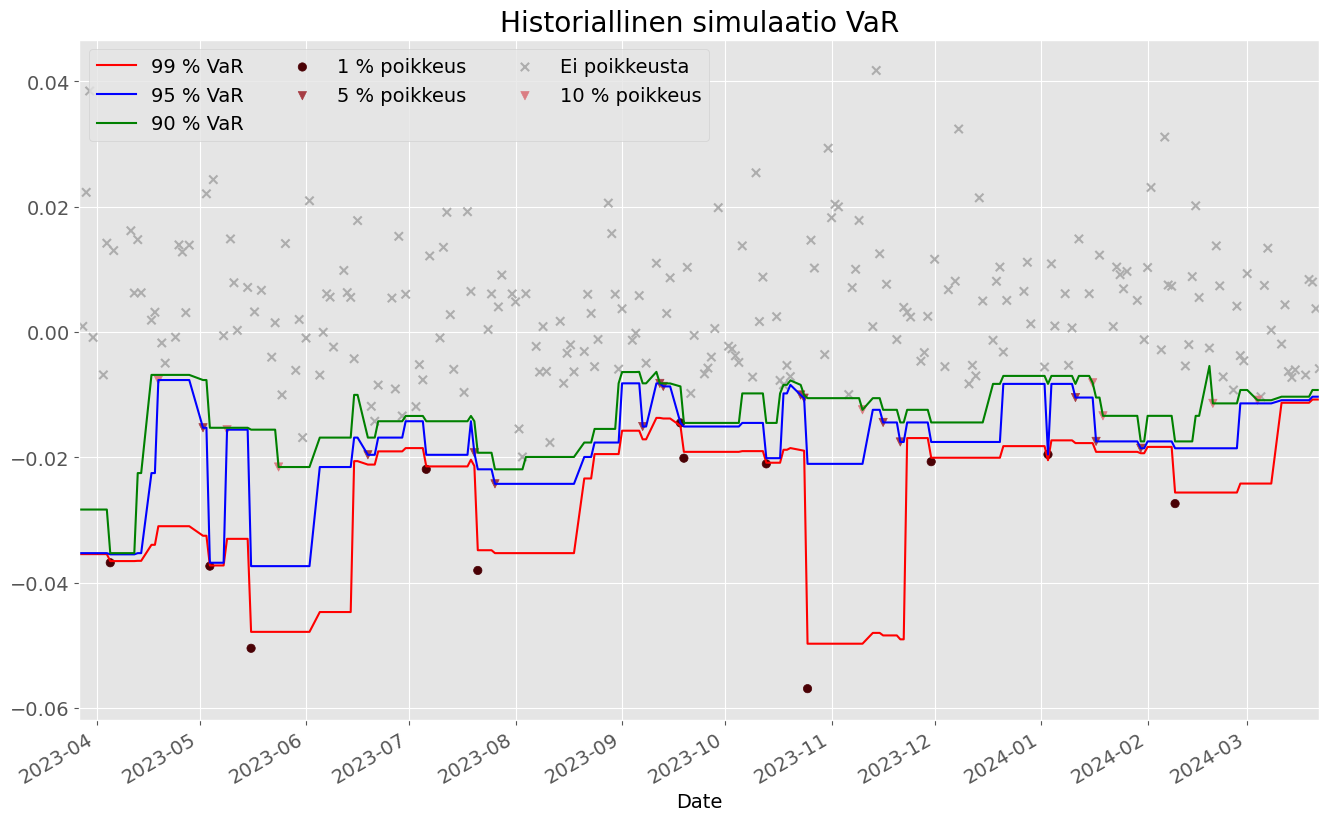

In [11]:
#Alkuperäinen plottauksen koodi, jota vahvasti muokattu: Kevin Sheppard (2021, March 3). bashtage/arch: Release 4.18 (Version v4.18). Zenodo. https://doi.org/10.5281/zenodo.593254
#VaR:n plottaus todellisia historiallisia portfolion tuottoja vastaan

value_at_risk = -VaRs
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
returns = historical_returns.tail(test_frame).copy()

#VaR aikasarjan yhden päivän viiveen asettaminen ja aikasarjojen indeksointi uudelleen

returns = returns[1:]
value_at_risk = value_at_risk[:-1]
value_at_risk.set_index(returns.index, inplace= True)

returns.name = "Stock returns"
c = []
for idx in value_at_risk.index:
    if returns[idx] < value_at_risk.loc[idx, "90 % VaR"] and returns[idx] > value_at_risk.loc[idx, "95 % VaR"]:
        c.append("#db7d83")
    elif returns[idx] > value_at_risk.loc[idx, "95 % VaR"]:
        c.append("#adadad")
    elif returns[idx] < value_at_risk.loc[idx, "99 % VaR"]:
        c.append("#4a0105")
    else:
        c.append("#a63d44")
c = np.array(c, dtype="object")
labels = {
    "#4a0105": "1 % poikkeus",
    "#a63d44": "5 % poikkeus",
    "#db7d83": "10 % poikkeus",
    "#adadad": "Ei poikkeusta",
    }
markers = {"#4a0105": "o", "#a63d44": "v", "#adadad": "x", "#db7d83": "v"}
for color in np.unique(c):
    sel = np.array([value == color for value in c])
    ax.scatter(
        returns.index[sel],
        returns.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Historiallinen simulaatio VaR")
leg = ax.legend(frameon=True, ncol=3)

leg_colors = ['r', 'b', 'g']
for i, text in enumerate(leg.get_lines()):
    text.set_color(leg_colors[i])

line_obj1 = plt.gca().get_lines()[0]
line_obj2 = plt.gca().get_lines()[1]
line_obj3 = plt.gca().get_lines()[2]

plt.setp(line_obj1, color="r")
plt.setp(line_obj2, color="b")
plt.setp(line_obj3, color="g")

plt.show()

In [13]:
#Z-testi suhteellisille osuuksille
#1 % ylittävien poikkeuksien kerääminen For -silmukalla

exceptions = []
for idx in value_at_risk.index:
    if returns[idx] < value_at_risk.loc[idx, "99 % VaR"]:
        exceptions.append(returns[idx])

#Testin parametrit. "expected_probability" -muuttuja on alustettu liukuluvulla 0.04,  
#joka vastaa 10 poikkeusta 250 päivän testijoukosta (0.04 * 250 = 10)

observed_successes = len(exceptions)
total_trials = len(value_at_risk)
expected_probability = 0.04

#Varsinainen testi

p_value = binomtest(k= observed_successes, n=total_trials, p=expected_probability, alternative= "less")
print(p_value)

BinomTestResult(k=12, n=250, alternative='less', statistic=0.048, pvalue=0.795467605584957)


In [14]:
#VaR:n ja negatiivisten tuottojen korrelaatio

df = pd.concat([value_at_risk["99 % VaR"], returns], axis= 1)
df = df.drop(df.index[df['Stock returns'] > 0])
corr = df.corr()
corr

,99 % VaR,Stock returns
99 % VaR,1.000000,0.008602
Stock returns,0.008602,1.000000
